In [23]:
# import packeges
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

In [24]:
# confirm version
import causalml
print(causalml.__version__)

0.11.0


In [25]:
# load data
base_path = "/Users/ryoto/workspace/hit-u/zemi/econome_ml_demo/data/"
mail = pd.read_csv(os.path.join(base_path,'E-MailAnalytics.csv'))
print(mail.shape)
mail.head()

(64000, 12)


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [26]:
# segment == Men's E-mail のデータのみで実験する
 = mail.query("segment != 'Womens E-Mail'")
["segment"] = .segment.map(lambda x: 1 if x == 'Mens E-Mail' else 0)
 = .rename(columns={"segment" : "treatment"})
.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,visit,conversion,spend
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,0,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,1,0,0,0.0
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,1,0,0,0.0
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,1,1,0,0.0
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,0,0,0,0.0


In [27]:
# ラベルエンコーディング（OrdinalEncoder）
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()
encoded = oe.fit_transform([['history_segment', 'zip_code', "channel"]].values)
# decoded = oe.inverse_transform(encoded)

print('エンコード結果: ')
encoded_df = pd.DataFrame(encoded, columns = ["history_segment", "zip_code", "channel"])
encoded_df.head()

_use = [
    ['recency', 'history', 'mens', 'womens', 'newbie', 'treatment', 'visit', 'conversion', 'spend']
    ]
demo_df = pd.concat([_use.reset_index(), encoded_df], axis = 1).drop(columns = "index")
print(demo_df.shape)
demo_df.head()

エンコード結果: 
(42613, 12)


,recency,history,mens,womens,newbie,treatment,visit,conversion,spend,history_segment,zip_code,channel
0,6,329.08,1,1,1,0,0,0,0.0,2.0,0.0,2.0
1,9,675.83,1,0,1,1,0,0,0.0,4.0,0.0,2.0
2,9,675.07,1,1,1,1,0,0,0.0,4.0,0.0,1.0
3,2,101.64,0,1,0,1,1,0,0.0,1.0,2.0,2.0
4,4,241.42,0,1,1,0,0,0,0.0,2.0,0.0,0.0


In [28]:
# treatment 0, 1 のデータフレームに分ける
treatment_1 = .query("treatment == 1")
treatment_0 = .query("treatment == 0")

# 介入が購買金額に与えた影響を計算する
ts_1 = treatment_1["spend"].mean()
ts_0 = treatment_0["spend"].mean()
print("介入が購買金額に与えた影響は,", np.round(ts_1 - ts_0, 3))

# 介入がconversionに与えた影響を計算する
tc_1 = treatment_1["conversion"].mean()
tc_0 = treatment_0["conversion"].mean()
True_ATE = np.round((tc_1 - tc_0), 5)
print("介入がconversionに与えた影響は,", True_ATE)

介入が購買金額に与えた影響は, 0.77
介入がconversionに与えた影響は, 0.00681


In [29]:
# set data 
def df_sample(df, sample_size:int, random_state:int):
    df = df.sample(sample_size, random_state = random_state)
    return df

demo_df_sampled = df_sample(demo_df, sample_size=2500, random_state=42)
print(demo_df_sampled.shape)
display(demo_df_sampled.head())

print("conversion == 0", len(demo_df_sampled) - demo_df_sampled[["conversion"]].sum())
print("conversion == 1", demo_df_sampled[["conversion"]].sum())

y = demo_df_sampled.conversion
T = demo_df_sampled.treatment
X = demo_df_sampled.drop(columns=["conversion", "treatment", "spend", "visit"])

(2500, 12)


,recency,history,mens,womens,newbie,treatment,visit,conversion,spend,history_segment,zip_code,channel
322,4,121.87,1,0,0,0,0,0,0.0,1.0,0.0,2.0
14339,3,184.83,1,0,1,1,0,0,0.0,1.0,2.0,1.0
2348,2,400.48,0,1,1,0,0,0,0.0,3.0,2.0,0.0
33454,10,175.25,0,1,0,1,1,0,0.0,1.0,0.0,2.0
25505,2,1640.42,1,1,1,1,0,0,0.0,6.0,0.0,0.0


conversion == 0 conversion    2478
dtype: int64
conversion == 1 conversion    22
dtype: int64


In [30]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

X = demo_df_sampled.drop(columns=["conversion", "spend", "visit"])
y = demo_df_sampled.conversion

# ランダムにover-sampling
sampler = RandomOverSampler(sampling_strategy=0.25, random_state=42)
X_res, y_res = sampler.fit_resample(X, y)
Counter(y_res)

display(X_res.head())

y = y_res
T = X_res.treatment
X = X_res.drop(columns=["treatment"])

print("conversion == 1", y.sum())
print("conversion == 0", len(y) - y.sum())

print(y.shape)
print(T.shape)
print(X.shape)

,recency,history,mens,womens,newbie,treatment,history_segment,zip_code,channel
0,4,121.87,1,0,0,0,1.0,0.0,2.0
1,3,184.83,1,0,1,1,1.0,2.0,1.0
2,2,400.48,0,1,1,0,3.0,2.0,0.0
3,10,175.25,0,1,0,1,1.0,0.0,2.0
4,2,1640.42,1,1,1,1,6.0,0.0,0.0


conversion == 1 619
conversion == 0 2478
(3097,)
(3097,)
(3097, 8)


# S-Learner

In [36]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=T, y=y)
print(ate_s)
print("True ATE : ", True_ATE)
print('ATE estimate: {:.05f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.05f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.05f}'.format(ate_s[2][0]))

(array([0.09257006]), array([0.06689763]), array([0.11824248]))
True ATE :  0.00681
ATE estimate: 0.09257
ATE lower bound: 0.06690
ATE upper bound: 0.11824


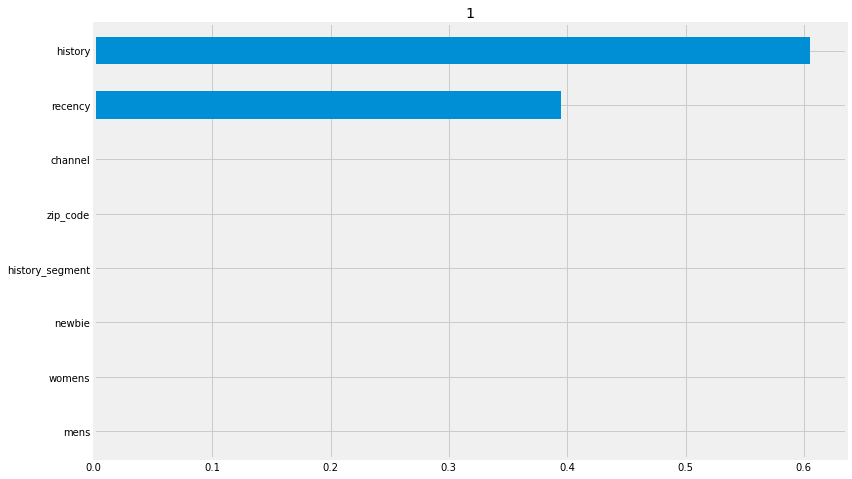

In [49]:
slearner_tau = learner_s.fit_predict(X, T, y)
learner_s.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=X.columns)

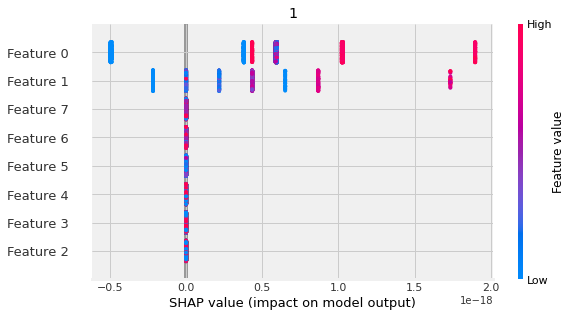

In [51]:
# Using SHAP
shap_slearner = learner_s.get_shap_values(X=X, tau=slearner_tau)

# Plot shap values without specifying shap_dict
learner_s.plot_shap_values(X=X, shap_dict=shap_slearner)

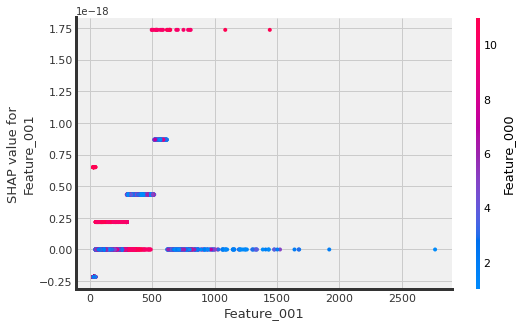

In [47]:
learner_s.plot_shap_dependence(treatment_group=1,
                            feature_idx=1,
                            X=X,
                            tau=slearner_tau,
                            interaction_idx='auto')

# T-Learner

In [32]:
# True ATE
print("True ATE : ", True_ATE)

# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=T, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)
print('ATE estimate: {:.05f}'.format(ate_t[0][0]))
print('ATE lower bound: {:.05f}'.format(ate_t[1][0]))
print('ATE upper bound: {:.05f}'.format(ate_t[2][0]))

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=T, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)
print('ATE estimate: {:.05f}'.format(ate_t[0][0]))
print('ATE lower bound: {:.05f}'.format(ate_t[1][0]))
print('ATE upper bound: {:.05f}'.format(ate_t[2][0]))

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=T, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)
print('ATE estimate: {:.05f}'.format(ate_t[0][0]))
print('ATE lower bound: {:.05f}'.format(ate_t[1][0]))
print('ATE upper bound: {:.05f}'.format(ate_t[2][0]))

True ATE :  0.00681
Using the ready-to-use XGBTRegressor class
(array([0.06494644]), array([0.04886087]), array([0.08103201]))
ATE estimate: 0.06495
ATE lower bound: 0.04886
ATE upper bound: 0.08103

Using the BaseTRegressor class and using XGB (same result):
(array([0.06494644]), array([0.04886087]), array([0.08103201]))
ATE estimate: 0.06495
ATE lower bound: 0.04886
ATE upper bound: 0.08103

Using the BaseTRegressor class and using Linear Regression (different result):
(array([0.0958001]), array([0.06889964]), array([0.12270056]))
ATE estimate: 0.09580
ATE lower bound: 0.06890
ATE upper bound: 0.12270


# X-Learner

In [33]:
# True ATE
print("True ATE : ", True_ATE)

# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=T, y=y)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)
print('ATE estimate: {:.05f}'.format(ate_x[0][0]))
print('ATE lower bound: {:.05f}'.format(ate_x[1][0]))
print('ATE upper bound: {:.05f}'.format(ate_x[2][0]))

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=T, y=y)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)
print('ATE estimate: {:.05f}'.format(ate_x[0][0]))
print('ATE lower bound: {:.05f}'.format(ate_x[1][0]))
print('ATE upper bound: {:.05f}'.format(ate_x[2][0]))

True ATE :  0.00681
Using the BaseXRegressor class and using XGB:
(array([0.04046557]), array([0.02954594]), array([0.0513852]))
ATE estimate: 0.04047
ATE lower bound: 0.02955
ATE upper bound: 0.05139

Using the BaseXRegressor class and using Linear Regression:
(array([0.0958001]), array([0.06889964]), array([0.12270056]))
ATE estimate: 0.09580
ATE lower bound: 0.06890
ATE upper bound: 0.12270
